### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
#!pip install tensorflow_decision_forests

### ライブラリをインポート
---


TensorFlowとデータ分析で使用するライブラリをインポートする。\
今回は、TensorFlow, pandas, numpy, matplotlibのライブラリを使用する。

In [2]:
# TensorFlow
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# Other
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

2023-09-29 03:34:15.198300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 03:34:15.258802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 03:34:15.259549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 03:34:16.466632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Check version
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


### データ取り込み
---


アメリカ アイオワ州戸建て住宅データをデータセットとして用いる。\
csvファイルのデータをpandasのデータフレーム型の変数に読み込む。\
列数は81列、データ数は1460データ。

In [4]:
# train.csv file read
train_file_path = './dataset/AIML_HousePrices/train.csv'
dataset_df = pd.read_csv(train_file_path)

In [5]:
print('Training用のデータセットの数は {}'.format(dataset_df.shape))

Training用のデータセットの数は (1460, 81)


In [6]:
dataset_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### データ前処理
----

ID列を削除

In [7]:
# drop Id column
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### データ分析
---

取り込んだデータを分析する。\
まずデータの全体像を把握するため、データ列名、データ型とNullの確認をする。

In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil


pandasライブラリのdescribe関数を使って、データ数(count)、平均値(mean)、標準偏差(std)、最小値(min)、最大値(max)などを確認する。

In [9]:
dataset_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



目的変数SalePriceの全体像の把握する。\
Matplotlibを使ってSalePriceのデータを価格ごとにグラフにする。

<function matplotlib.pyplot.show(close=None, block=None)>

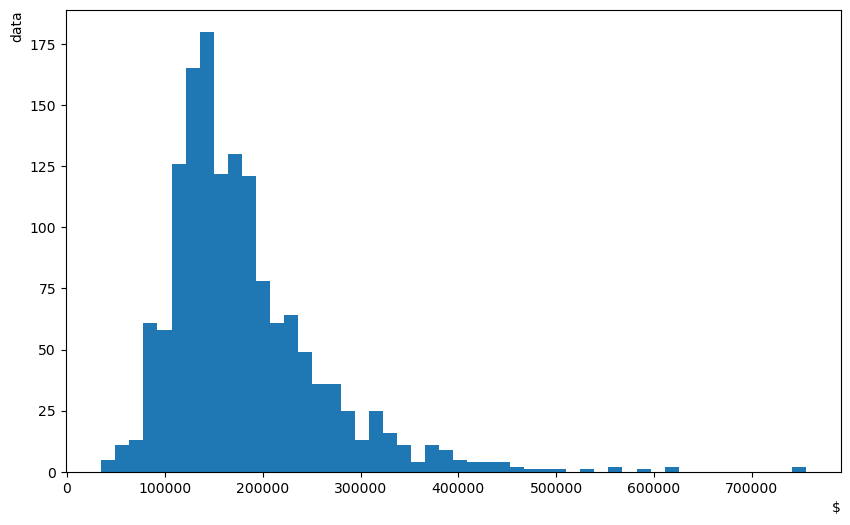

In [10]:
plt.figure(figsize=(10,6))
plt.hist(dataset_df['SalePrice'], bins=50)
plt.xlabel('$', loc='right')
plt.ylabel('data', loc='top')
plt.show

特徴量データの可視化\
データセット全体の特徴を把握\
数値のデータの列をヒストグラムにした。


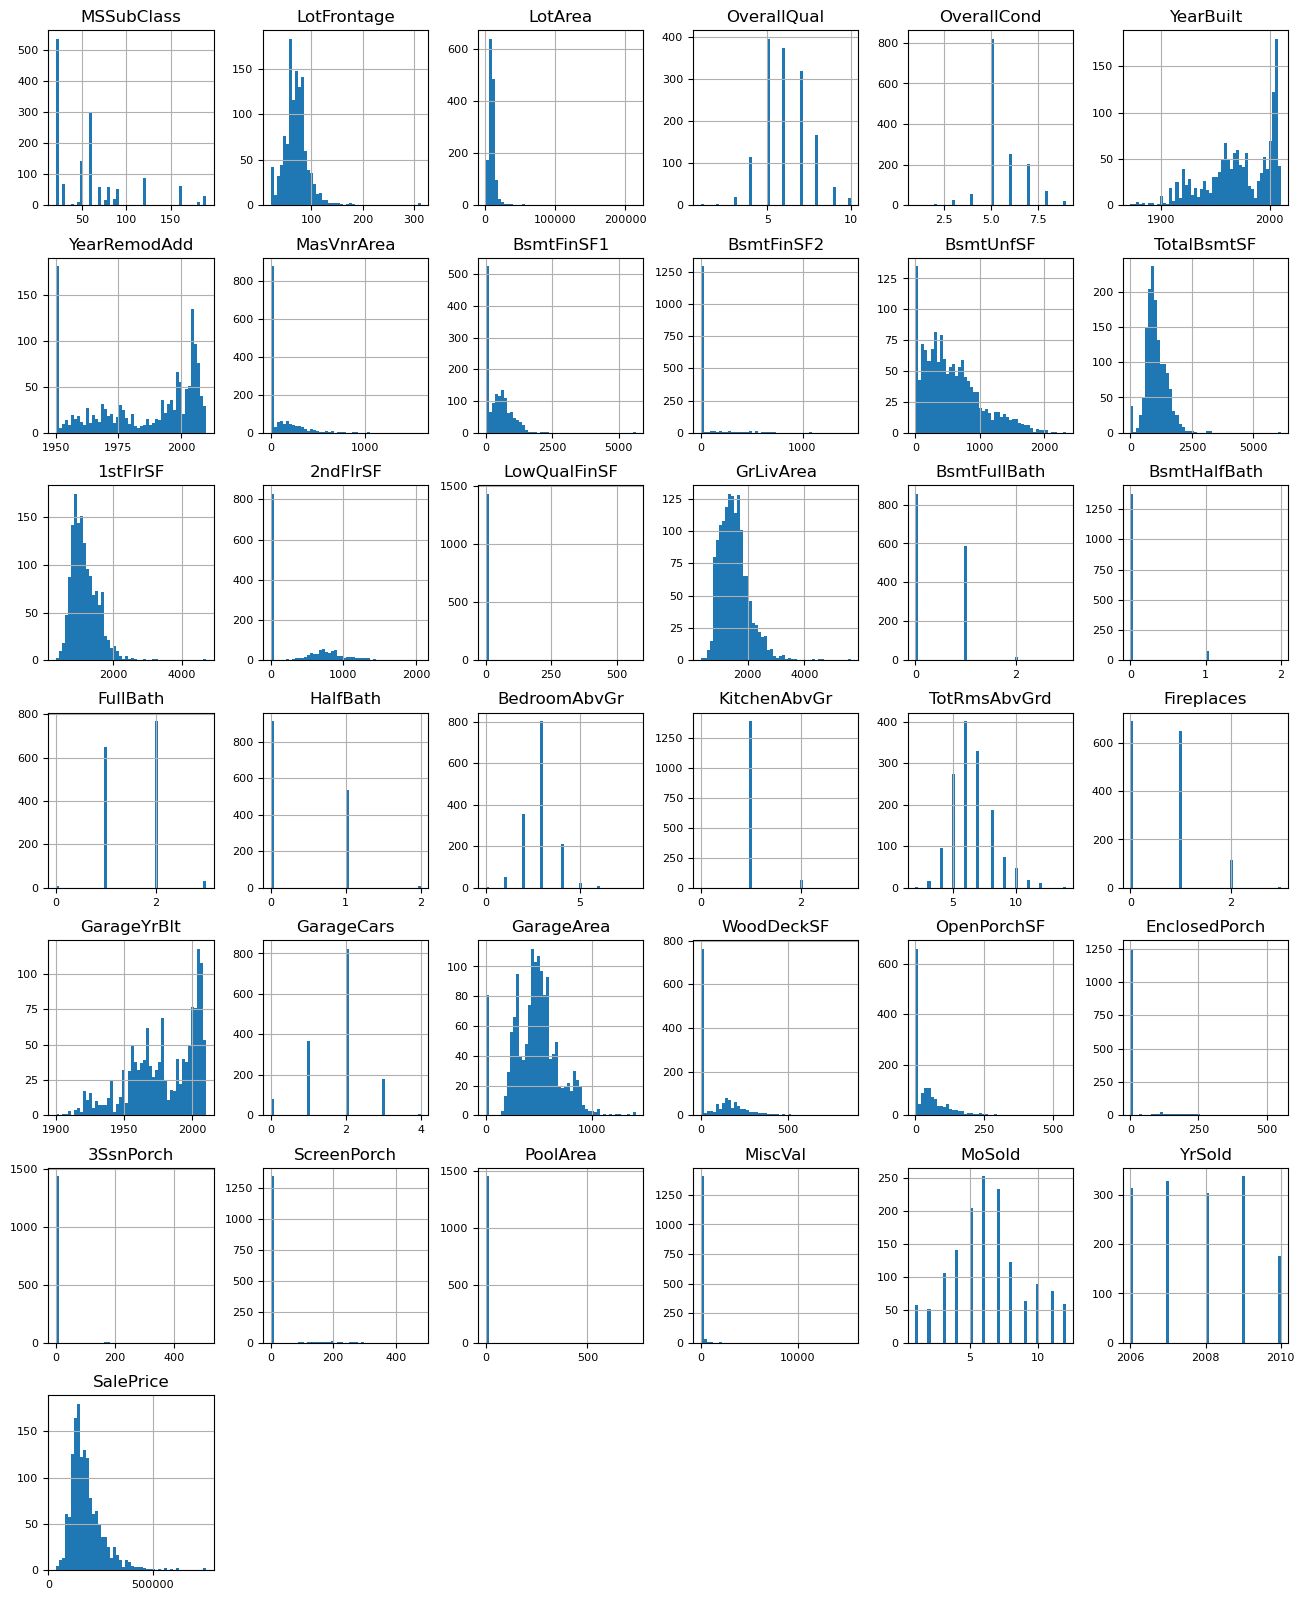

In [11]:
df_num = dataset_df.select_dtypes(exclude=['object'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### モデル学習
----


まずモデルのトレーニング用データセットと検証用データセットに分割

In [12]:
# data split
def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

In [13]:
train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("トレーニング用データ {}, 検証用データ {} ".format(
    len(train_ds_pd), len(valid_ds_pd)))

トレーニング用データ 1018, 検証用データ 442 



分割したPandasのデータフレームをTensorFlow用のデータ型に変換

In [14]:
# Convert the dataset
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label = label, task = tfdf.keras.Task.REGRESSION)

### モデルを構築
----

機械学習のアルゴリズム"ランダムフォレスト"を使用する

--ランダムフォレストとは\
複数の決定木の出力を組み合わせて1つの結果を出力するアルゴリズム。\
決定木は、「部屋は広いか」「車は持っているのか」などの基本的な質問を複数行い答えを判断する。\
質問ごとに決定木内の決定ノードを構成し、「Yes」「No」の分岐を繰り返しデータを分割する手段として用いられる。

ランダムフォレストは、相関性のない複数の決定木の森を構成する。\
複数の決定木の結果をもとに予測値を決定する。\
回帰問題の場合、ここの決定木の平均で予測値が決定される

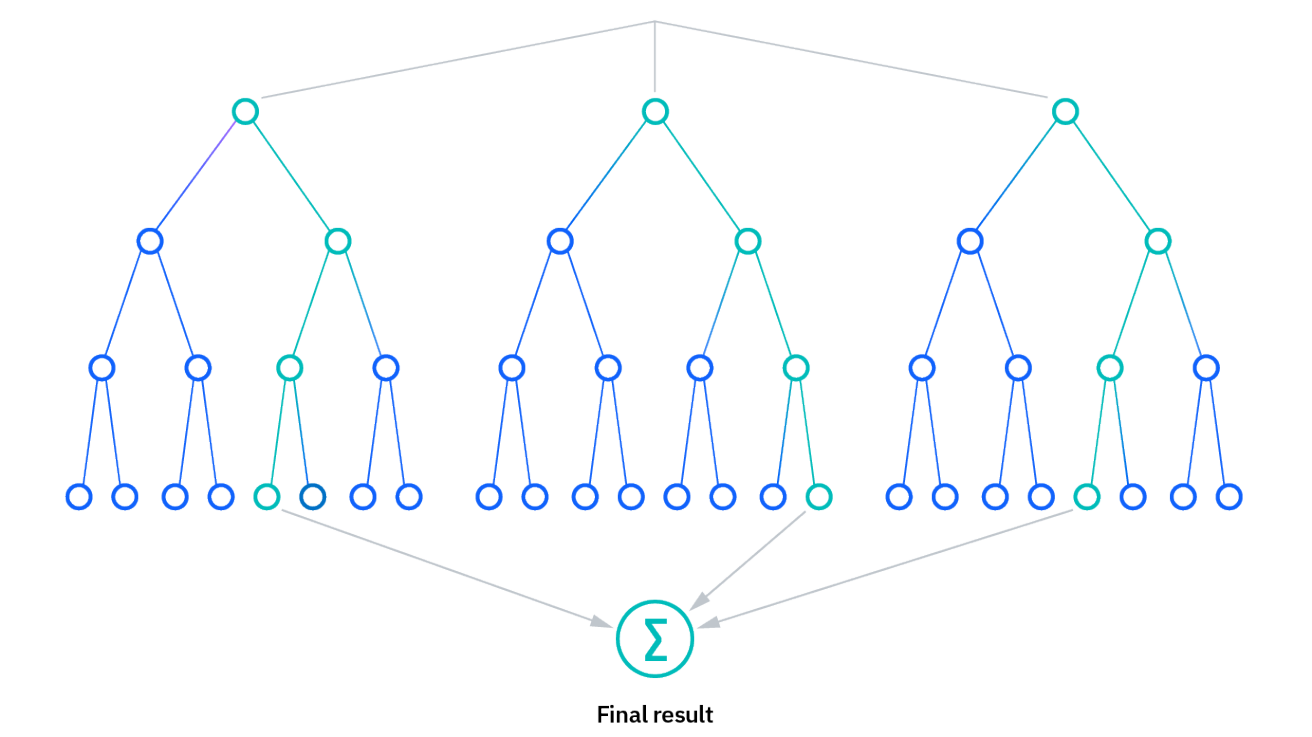

Tensorflowのライブラリからランダムフォレストのモジュールを取得する

In [15]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmpk5vjo9gn as temporary training directory


アルゴリズムに数値を入力しモデルを作成する

In [16]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:05.483859. Found 1018 examples.
Training model...
Model trained in 0:00:02.551539


[INFO 23-09-29 03:34:32.2607 UTC kernel.cc:1243] Loading model from path /tmp/tmpk5vjo9gn/model/ with prefix 57496ed7abb04d0b
[INFO 23-09-29 03:34:32.4477 UTC decision_forest.cc:660] Model loaded with 300 root(s), 96752 node(s), and 75 input feature(s).
[INFO 23-09-29 03:34:32.4477 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-29 03:34:32.4481 UTC kernel.cc:1075] Use fast generic engine


Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.



トレーニングデータから作成した、ランダムフォレストの決定木モデルを図に表示

In [17]:
# Visualize the model
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

### モデル分析/検証
----

モデルを使った予測値と実際の値の比較をする\
まず予測値を確認する。

In [18]:
# prediction
preds = rf.predict(valid_ds)
preds_output1 = pd.DataFrame({'SalePrice': preds.squeeze()})
preds_output1.head()

1/1 [==============================] - 0s 163ms/step


,SalePrice
0,205110.234375
1,145951.687500
2,274469.093750
3,153326.765625
4,131030.148438


実際の値を確認する。

In [19]:
actual_output1 = pd.DataFrame({'SalePrice': valid_ds_pd['SalePrice']})
actual_output1.head()

,SalePrice
0,208500
5,143000
6,307000
8,129900
10,129500


今回は、回帰問題の一般的な評価方法のひとつである、平均二乗誤差（MSE）を使ってモデルを評価する。\
そして、目的変数に対する変数の重要度も確認する。

In [20]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1018, accuracy=None, loss=None, rmse=26842.295410800536, ndcg=None, aucs=None, auuc=None, qini=None)

平均二乗誤差(MSE)の計算

In [21]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 585ms/step - loss: 0.0000e+00 - mse: 1091744512.0000
loss: 0.0000
mse: 1091744512.0000



目的変数(SalePrice)に影響を与えている列名

In [22]:
# Variable Importances
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


In [23]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 125.0),
 ("Neighborhood" (4; #59), 49.0),
 ("ExterQual" (4; #22), 42.0),
 ("GarageCars" (1; #32), 34.0),
 ("GrLivArea" (1; #38), 26.0),
 ("GarageArea" (1; #31), 9.0),
 ("TotalBsmtSF" (1; #73), 5.0),
 ("YearBuilt" (1; #76), 4.0),
 ("BsmtQual" (4; #14), 2.0),
 ("FullBath" (1; #29), 2.0),
 ("1stFlrSF" (1; #0), 1.0),
 ("KitchenQual" (4; #44), 1.0)]

----
## 機械学習サイクル 2週目
----

### データ前処理
----

1週目と同様に、データの取り込みとID列の削除を行う

In [24]:
# train.csv file read
train_file_path_2 = './dataset/AIML_HousePrices/train.csv'
dataset_df2 = pd.read_csv(train_file_path_2)

# drop Id column
dataset_df2 = dataset_df2.drop('Id', axis=1)
dataset_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil


欠損値補完\
Nullデータを"None"という文字列で埋める

In [25]:
# Missing Value Filling
dataset_df2["PoolQC"] = dataset_df2["PoolQC"].fillna("None")
dataset_df2["MiscFeature"] = dataset_df2["MiscFeature"].fillna("None")
dataset_df2["Alley"] = dataset_df2["Alley"].fillna("None")
dataset_df2["Fence"] = dataset_df2["Fence"].fillna("None")
dataset_df2["FireplaceQu"] = dataset_df2["FireplaceQu"].fillna("None")


データ列の追加 \
全部で5列追加する.


1:住宅が販売されるまでの年数 \
2:修理が行われるまでの年数 \
3:総フロア面積 \
4:ガレージに関する特徴量 \
5:リモデルされたか

In [26]:
# Add Clumns
dataset_df2.loc[:, 'YearsBeforeSale'] = dataset_df2['YrSold'] - dataset_df2['YearBuilt']
dataset_df2.loc[:, 'YearsSinceRemodel'] = dataset_df2['YrSold'] - dataset_df2['YearRemodAdd']
dataset_df2.loc[:, 'TotalSF'] = dataset_df2['TotalBsmtSF'] + dataset_df2['1stFlrSF'] + dataset_df2['2ndFlrSF']
dataset_df2.loc[:, 'GarageAreaPerCar'] = dataset_df2['GarageArea'] / (dataset_df2['GarageCars'] + 1)
dataset_df2.loc[:, 'Remodeled'] = (dataset_df2['YearBuilt'] != dataset_df2['YearRemodAdd']).astype(int)

dataset_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 85 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int64  
 1   MSZoning           1460 non-null   object 
 2   LotFrontage        1201 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   Street             1460 non-null   object 
 5   Alley              1460 non-null   object 
 6   LotShape           1460 non-null   object 
 7   LandContour        1460 non-null   object 
 8   Utilities          1460 non-null   object 
 9   LotConfig          1460 non-null   object 
 10  LandSlope          1460 non-null   object 
 11  Neighborhood       1460 non-null   object 
 12  Condition1         1460 non-null   object 
 13  Condition2         1460 non-null   object 
 14  BldgType           1460 non-null   object 
 15  HouseStyle         1460 non-null   object 
 16  OverallQual        1460 

外れ値の除去
SalePriceが＄700,000以上の外れ値を除外する。

In [27]:
dataset_df2 = dataset_df2[(dataset_df2['SalePrice']<700000)]
dataset_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 85 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1458 non-null   int64  
 1   MSZoning           1458 non-null   object 
 2   LotFrontage        1199 non-null   float64
 3   LotArea            1458 non-null   int64  
 4   Street             1458 non-null   object 
 5   Alley              1458 non-null   object 
 6   LotShape           1458 non-null   object 
 7   LandContour        1458 non-null   object 
 8   Utilities          1458 non-null   object 
 9   LotConfig          1458 non-null   object 
 10  LandSlope          1458 non-null   object 
 11  Neighborhood       1458 non-null   object 
 12  Condition1         1458 non-null   object 
 13  Condition2         1458 non-null   object 
 14  BldgType           1458 non-null   object 
 15  HouseStyle         1458 non-null   object 
 16  OverallQual        1458 

### モデル学習
----


トレーニング用データセットと検証用データセットに分割

In [28]:
train_ds_pd2, valid_ds_pd2 = split_dataset(dataset_df2)
print("トレーニング用データ {}, 検証用データ {} ".format(
    len(train_ds_pd2), len(valid_ds_pd2)))

トレーニング用データ 1040, 検証用データ 418 


In [29]:
# Convert the dataset
label = 'SalePrice'
train_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd2, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd2, label = label, task = tfdf.keras.Task.REGRESSION)

### モデルを構築
----

"ランダムフォレスト"というアルゴリズムを使用

In [30]:
rf2 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf2.compile(metrics=["mse"])

Use /tmp/tmpfrv4nx0e as temporary training directory


In [31]:
rf2.fit(x=train_ds2)

Reading training dataset...
Training dataset read in 0:00:01.049369. Found 1040 examples.
Training model...


[INFO 23-09-29 03:34:44.6808 UTC kernel.cc:1243] Loading model from path /tmp/tmpfrv4nx0e/model/ with prefix c87f1d03634f4d0e


Model trained in 0:00:02.503153
Compiling model...


[INFO 23-09-29 03:34:44.8850 UTC decision_forest.cc:660] Model loaded with 300 root(s), 98894 node(s), and 81 input feature(s).
[INFO 23-09-29 03:34:44.8850 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-29 03:34:44.8851 UTC kernel.cc:1075] Use fast generic engine


Model compiled.


In [32]:
# Visualize the model
tfdf.model_plotter.plot_model_in_colab(rf2, tree_idx=0, max_depth=3)

### モデル分析/検証
----

検証用データを使い、モデルを使った予測値と実際の値の比較をする\
まず予測値を確認する。

In [33]:
# prediction
preds2 = rf2.predict(valid_ds2)
preds_output2 = pd.DataFrame({'SalePrice': preds2.squeeze()})
preds_output2.head()

1/1 [==============================] - 0s 162ms/step


,SalePrice
0,214311.562500
1,180983.734375
2,121193.656250
3,341799.250000
4,143767.953125


実際の値を確認する。

In [34]:
actual_output2 = pd.DataFrame({'SalePrice': valid_ds_pd2['SalePrice']})
actual_output2.head()

,SalePrice
2,223500
3,140000
9,118000
11,345000
16,149000


In [35]:
inspector2 = rf2.make_inspector()
inspector2.evaluation()

Evaluation(num_examples=1040, accuracy=None, loss=None, rmse=27060.040291072448, ndcg=None, aucs=None, auuc=None, qini=None)

平均二乗誤差(MSE)の計算

In [36]:
evaluation2 = rf2.evaluate(x=valid_ds2,return_dict=True)

for name, value in evaluation2.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 332ms/step - loss: 0.0000e+00 - mse: 700611264.0000
loss: 0.0000
mse: 700611264.0000



1周目と２週目の平均絶対誤差を比較

In [37]:
print(f" 1st Cycle: {evaluation['mse']}\n 2nd Cycle: {evaluation2['mse']}")

 1st Cycle: 1091744512.0
 2nd Cycle: 700611264.0


In [38]:
inspector2.variable_importances()["NUM_AS_ROOT"]

[("TotalSF" (1; #76), 99.0),
 ("OverallQual" (1; #63), 81.0),
 ("ExterQual" (4; #22), 38.0),
 ("Neighborhood" (4; #60), 21.0),
 ("GrLivArea" (1; #39), 19.0),
 ("GarageCars" (1; #33), 18.0),
 ("YearsBeforeSale" (1; #81), 7.0),
 ("KitchenQual" (4; #45), 5.0),
 ("BsmtQual" (4; #14), 3.0),
 ("TotalBsmtSF" (1; #75), 3.0),
 ("GarageArea" (1; #31), 2.0),
 ("GarageYrBlt" (1; #38), 2.0),
 ("YearBuilt" (1; #79), 2.0)]

### モデルをKaggleのテストデータに適応
----

今回使用したデータセットは機械学習のコンペサイト”Kaggle”の問題から取ってきた。\
結果をKaggleに投稿することで、モデルに対するスコアを出してくれる。

１周目のモデルをTestdataに適応

In [39]:
# Prediction dataset
test_file_path = './dataset/AIML_HousePrices/test.csv'
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

In [40]:
# prediction
preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})

2/2 [==============================] - 1s 24ms/step


In [41]:
# Submit
sample_submission_df = pd.read_csv('./dataset/AIML_HousePrices/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('./submit/submission_1.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 23ms/step


,Id,SalePrice
0,1461,122933.968750
1,1462,149286.750000
2,1463,184516.531250
3,1464,181393.765625
4,1465,196360.906250


2周目のモデルをTestdataに適応

In [ ]:
# Prediction dataset
test_file_path2 = './dataset/AIML_HousePrices/test.csv'
test_data2 = pd.read_csv(test_file_path2)
ids2 = test_data2.pop('Id')

# Missing Value Filling
test_data2["PoolQC"] = test_data2["PoolQC"].fillna("None")
test_data2["MiscFeature"] = test_data2["MiscFeature"].fillna("None")
test_data2["Alley"] = test_data2["Alley"].fillna("None")
test_data2["Fence"] = test_data2["Fence"].fillna("None")
test_data2["FireplaceQu"] = test_data2["FireplaceQu"].fillna("None")

# Add Clumns
test_data2.loc[:, 'YearsBeforeSale'] = test_data2['YrSold'] - test_data2['YearBuilt']
test_data2.loc[:, 'YearsSinceRemodel'] = test_data2['YrSold'] - test_data2['YearRemodAdd']
test_data2.loc[:, 'TotalSF'] = test_data2['TotalBsmtSF'] + test_data2['1stFlrSF'] + test_data2['2ndFlrSF']
test_data2.loc[:, 'GarageAreaPerCar'] = test_data2['GarageArea'] / (test_data2['GarageCars'] + 1)
test_data2.loc[:, 'Remodeled'] = (test_data2['YearBuilt'] != test_data2['YearRemodAdd']).astype(int)

test_ds2 = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data2,
    task = tfdf.keras.Task.REGRESSION)

In [ ]:
# prediction
preds2 = rf2.predict(test_ds2)
output2 = pd.DataFrame({'Id': ids2, 'SalePrice': preds2.squeeze()})

In [ ]:
# Submit2
sample_submission_df2 = pd.read_csv('./dataset/AIML_HousePrices/sample_submission.csv')
sample_submission_df2['SalePrice'] = rf2.predict(test_ds2)
sample_submission_df2.to_csv('./submit/submission_2.csv', index=False)
sample_submission_df2.head()